In [1]:
import os
import sys
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

img1 = cv2.imread("panorama_dataset/image1.png")
img2 = cv2.imread("panorama_dataset/image2.png")

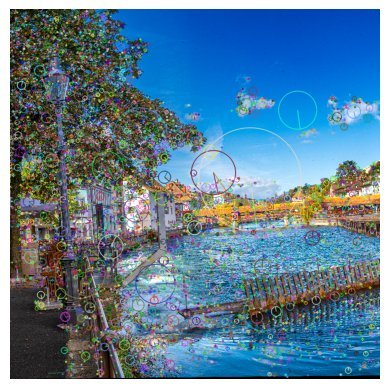

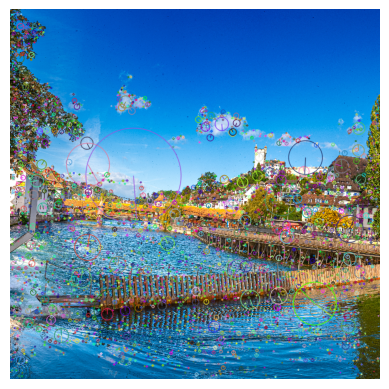

In [2]:

def detect_keypoints(image, draw=False):
    """
    Detects keypoints using SIFT and draws them on the image.
    """
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Initialize SIFT detector
    sift = cv2.SIFT_create()
    
    # Detect keypoints and compute descriptors
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    
    if draw:
        # Draw keypoints on the image
        keypoints_image = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        plt.imshow(cv2.cvtColor(keypoints_image, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.show()
    
    return keypoints, descriptors

# Detect and draw keypoints on the images
kp1, desc1 = detect_keypoints(img1, draw=True)
kp2, desc2 = detect_keypoints(img2, draw=True)

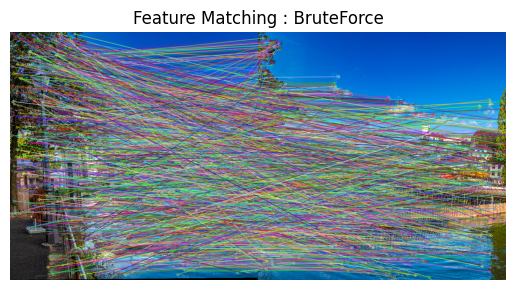

Number of matches using BruteForce: 1857


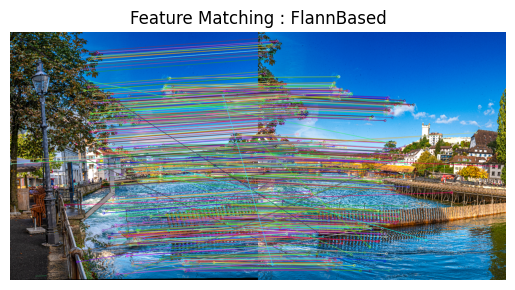

Number of matches using FlannBased: 686


In [3]:
def match_features(img1, kp1, desc1, img2, kp2, desc2, method="BF", draw=False):
    """
    Matches features using BruteForce or FlannBased method and optionally draws them.
    """
    if method == "BruteForce":
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
        matches = bf.match(desc1, desc2)

    elif method == "FlannBased":
        index_params = dict(algorithm=1, trees=5)
        search_params = dict(checks=50)
        flann = cv2.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(desc1, desc2, k=2)

        # Apply ratio test to filter matches
        good_matches = []
        for match1, match2 in matches:
            if match1.distance < 0.75 * match2.distance:
                good_matches.append(match1)
        matches = good_matches

    else : 
        raise ValueError("Method must be either 'BruteForce' or 'FlannBased'")
    
    
    matches = sorted(matches, key=lambda x: x.distance)
    
    if draw:
        matched_image = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB))
        plt.title("Feature Matching : " + method)
        plt.axis("off")
        plt.show()
    
    return matches

bf_matches = match_features(img1, kp1, desc1, img2, kp2, desc2, method="BruteForce", draw=True)
print(f"Number of matches using BruteForce: {len(bf_matches)}")
flann_matches = match_features(img1, kp1, desc1, img2, kp2, desc2, method="FlannBased", draw=True)
print(f"Number of matches using FlannBased: {len(flann_matches)}")  

In [4]:
def compute_homography(kp1, kp2, matches):
    """
    Computes the Homography matrix using RANSAC and saves it as a CSV file.
    """
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    
    return H


H = compute_homography(kp1, kp2, flann_matches)
print("Homography matrix (FlannBased Matching) :")
print(H)
# Save the homography matrix to a CSV file
homography_df = pd.DataFrame(H)
homography_df.to_csv("homography_matrix.csv", index=False, header=False)
print("Homography matrix saved to homography_matrix.csv")

Homography matrix (FlannBased Matching) :
[[ 8.98903904e-01 -1.31281699e-01 -1.64422248e+02]
 [ 1.43239019e-01  9.90457145e-01 -6.94247988e+01]
 [-1.89979582e-07  1.06312086e-07  1.00000000e+00]]
Homography matrix saved to homography_matrix.csv


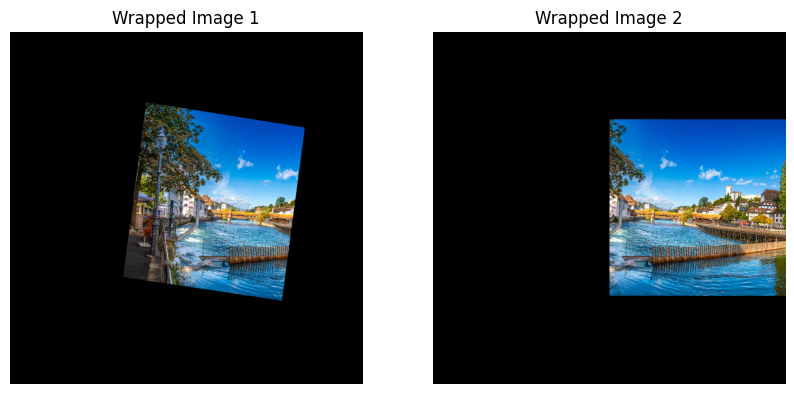

In [5]:
def warp_perspective(img1, img2, H, draw=False):
    """
    Applies perspective warping to both images using the homography matrix.
    """

    # Get image sizes
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    # Adjust translation to keep everything in positive space
    translation = np.array([[1, 0, w1], [0, 1, h1//2], [0, 0, 1]]).astype(np.float32)
    H_adjusted = np.dot(translation, H)
    wrapped_img1 = cv2.warpPerspective(img1, H_adjusted, (w1+w2, h1+h2))
    wrapped_img2 = cv2.warpPerspective(img2, translation, (w1+w2, h1+h2))
    
    if draw:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(wrapped_img1, cv2.COLOR_BGR2RGB))
        plt.title("Wrapped Image 1")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(wrapped_img2, cv2.COLOR_BGR2RGB))
        plt.title("Wrapped Image 2")
        plt.axis("off")

        plt.show()
    
    return wrapped_img1, wrapped_img2

wrapped_img1, wrapped_img2 = warp_perspective(img1, img2, H, draw=True)

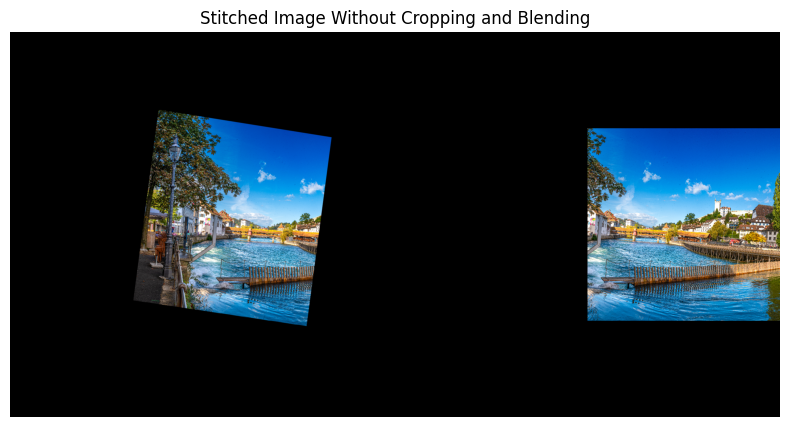

In [6]:
def stitch_without_crop_and_blend(wrapped_img1,wrapped_img2,draw=False):
    """
    Stitches the two images without cropping and blending.
    """
    # Get image sizes
    h1, w1 = wrapped_img1.shape[:2]
    h2, w2 = wrapped_img2.shape[:2]

    # Create a blank canvas for the stitched image
    stitched_image = np.zeros((max(h1, h2), w1 + w2, 3), dtype=np.uint8)

    # Place the first image on the canvas
    stitched_image[:h1, :w1] = wrapped_img1

    # Place the second image on the canvas
    stitched_image[:h2, w1:w1 + w2] = wrapped_img2

    if draw:
        plt.figure(figsize=(10, 5))
        plt.imshow(cv2.cvtColor(stitched_image, cv2.COLOR_BGR2RGB))
        plt.title("Stitched Image Without Cropping and Blending")
        plt.axis("off")
        plt.show()

    return stitched_image

stitched_image_without_crop_and_blend = stitch_without_crop_and_blend(wrapped_img1, wrapped_img2, draw=True)

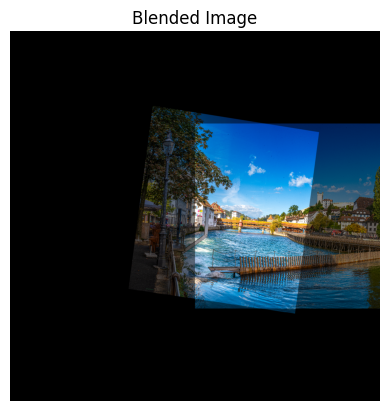

In [7]:
def blend(wrapped_img1,wrapped_img2,draw=False):
    """
    Blends the two images using linear blending.
    """

    alpha = 0.5  # Blending factor  
    beta = 1 - alpha
    blended_image = cv2.addWeighted(wrapped_img1, alpha, wrapped_img2, beta, 0)

    if draw:
        plt.imshow(cv2.cvtColor(blended_image, cv2.COLOR_BGR2RGB))
        plt.title("Blended Image")
        plt.axis("off")
        plt.show()

    return blended_image

blended_image = blend(wrapped_img1, wrapped_img2, draw=True)

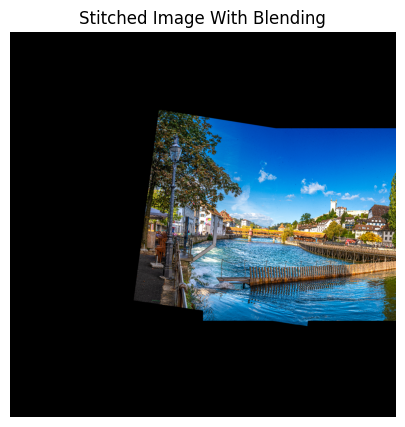

In [8]:
def stitch_with_blend(img1, img2, H, draw=False):

    wrapped_img1, wrapped_img2 = warp_perspective(img1, img2, H, draw=False)

    stitched_image = wrapped_img1.copy()
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    # Create a mask for the second image
    stitched_image[h1//2 : h1//2 + h2, w1:w1+w2] = wrapped_img2[ h1//2 : h1//2 + h2 , w1:w1+w2]

    if draw:
        plt.figure(figsize=(10, 5))
        plt.imshow(cv2.cvtColor(stitched_image, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title("Stitched Image With Blending")
        plt.show()

    return stitched_image

stitched_image_with_blend = stitch_with_blend(img1, img2, H, draw=True)

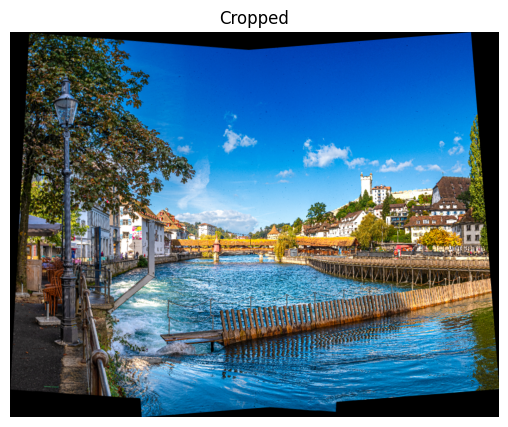

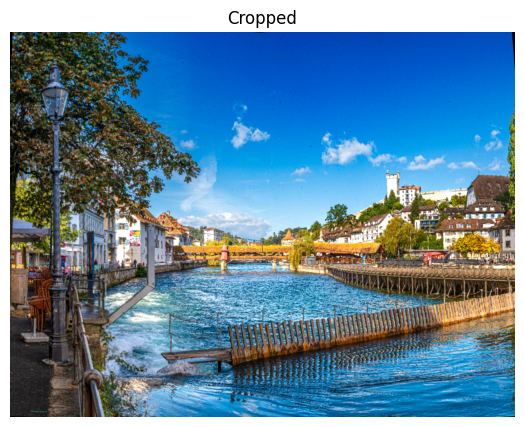

In [24]:
# def basic_crop(image, draw=False):
#     # Convert to grayscale and create a mask of non-black pixels
#     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     mask = gray > 0  # Non-black pixels

#     # Find bounding box of non-black pixels
#     y_indices, x_indices = np.where(mask)
#     x_min, x_max = x_indices.min(), x_indices.max()
#     y_min, y_max = y_indices.min(), y_indices.max()

#     # Crop the image to the valid region
#     cropped_image = image[y_min:y_max, x_min:x_max]

#     if draw:
#         plt.figure(figsize=(10, 5))
#         plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
#         plt.axis("off")
#         plt.title("Basic Cropped")
#         plt.show()

#     return cropped_image

def crop(image, threshold=0.0, draw=False):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Create a binary mask (all non-black pixels are white)
    _, binary = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

    # Find contours of the non-black region
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return image  # Return as-is if no valid region is found

    # Find the minimum area rectangle around the largest contour
    largest_contour = max(contours, key=cv2.contourArea)
    rect = cv2.minAreaRect(largest_contour)
    box = cv2.boxPoints(rect)
    box = np.intp(box)

    # Get width and height of the rectangle
    width = int(rect[1][0])
    height = int(rect[1][1])

    # Get perspective transform matrix
    src_pts = box.astype("float32")  # Source points (rotated rectangle)
    dst_pts = np.array([[0, height-1], [0, 0], [width-1, 0], [width-1, height-1]], dtype="float32")  # Destination points

    # Apply perspective transform
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    cropped_img = cv2.warpPerspective(image, M, (width, height))

    if width < height:
        # Rotate the cropped image 90 degrees clockwise
        cropped_img = cv2.rotate(cropped_img, cv2.ROTATE_90_CLOCKWISE)

    # Convert to grayscale and create a mask of non-black pixels
    gray = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2GRAY)
    binary = gray > 0  # Non-black pixels
    h,w = cropped_img.shape[:2]

    # Define function to check percentage of non-black pixels in a row/column
    def non_black_ratio(arr):
        return np.count_nonzero(arr) / len(arr)
    
    # Crop from the top
    top = 0
    while top < h and non_black_ratio(binary[top, :]) < threshold:
        top += 1

    # Crop from the bottom
    bottom = h - 1
    while bottom > top and non_black_ratio(binary[bottom, :]) < threshold:
        bottom -= 1

    cropped_img = cropped_img[top:bottom+1, :]

    gray = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2GRAY)
    binary = gray > 0  # Non-black pixels
    h,w = cropped_img.shape[:2]

    # Crop from the left
    left = 0
    while left < w and non_black_ratio(binary[:, left]) < threshold:
        left += 1

    # Crop from the right
    right = w - 1
    while right > left and non_black_ratio(binary[:, right]) < threshold:
        right -= 1

    # Crop the image
    cropped_img = cropped_img[:, left:right+1]

    # Show the final cropped image if draw=True
    if draw:
        plt.figure(figsize=(10, 5))
        plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title("Cropped")
        plt.show()

    return cropped_img

basic_cropped_image = crop(stitched_image_with_blend, draw=True)
advanced_cropped_image = crop(stitched_image_with_blend, threshold=0.90, draw=True)

In [10]:
image_paths = [os.path.join("panorama_dataset", img) for img in os.listdir("panorama_dataset")]

# Function to compute color histograms
def color_histograms(image_paths, bins=8):
    histograms = []
    for img_path in image_paths:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        hist_r = cv2.calcHist([img], [0], None, [bins], [0, 256])
        hist_g = cv2.calcHist([img], [1], None, [bins], [0, 256])
        hist_b = cv2.calcHist([img], [2], None, [bins], [0, 256])
        hist = np.concatenate((hist_r, hist_g, hist_b)).flatten()
        histograms.append(hist)
    return np.array(histograms)

# Function to compute visual bag of words (BoW) features
def bag_of_words(image_paths, n_clusters=20):
    bow_features = []
    # Create a KMeans model for clustering
    kmeans = KMeans(n_clusters=10, random_state=42)
    
    for img_path in image_paths:
        keypoints, descriptors = detect_keypoints(cv2.imread(img_path))
        
        if descriptors is not None:
            # Cluster the descriptors using KMeans
            kmeans.fit(descriptors)
            bow_hist = np.bincount(kmeans.labels_, minlength=n_clusters)
            bow_features.append(bow_hist)
        else:
            bow_features.append(np.zeros(n_clusters))
    
    return np.array(bow_features)

# Function to perform K-means clustering
def cluster_images(features, n_clusters=3):    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(features)
    return labels

# Visualize results
def visualize_clusters(image_paths, labels, title):    
    for cluster in np.unique(labels):
        cluster_indices = np.where(labels == cluster)[0]
        fig, ax = plt.subplots(1, len(cluster_indices), figsize=(20, 2 ))
        plt.suptitle(f"{title} - Cluster {cluster}")
        
        for i, idx in enumerate(cluster_indices):
            img = cv2.imread(image_paths[idx])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ax[i].imshow(img)
            ax[i].axis("off")
            plt.imshow(img)
        
        plt.show()

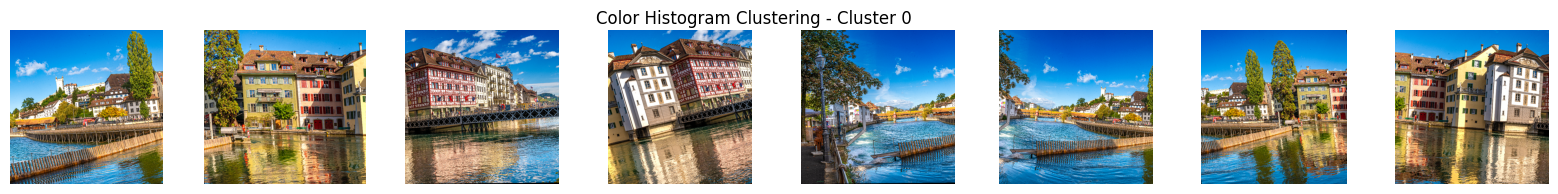

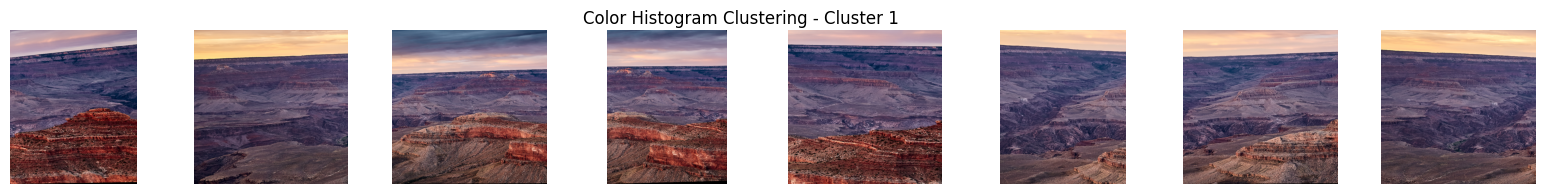

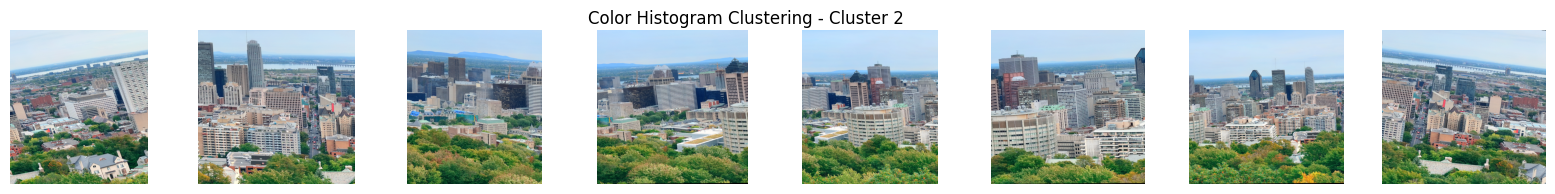

In [11]:
color_hist_features = color_histograms(image_paths)
color_hist_labels = cluster_images(color_hist_features, n_clusters=3)
visualize_clusters(image_paths, color_hist_labels, "Color Histogram Clustering")

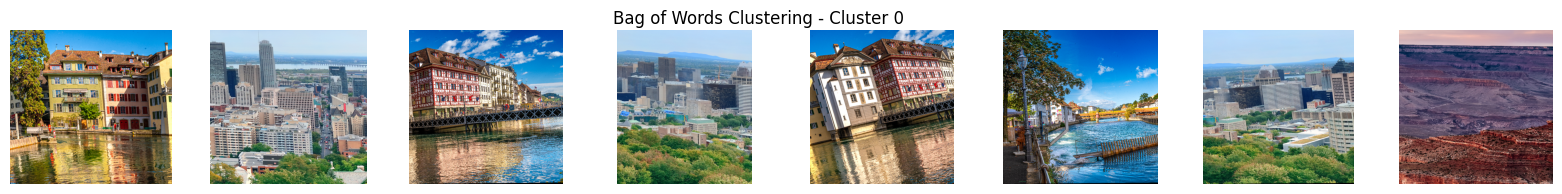

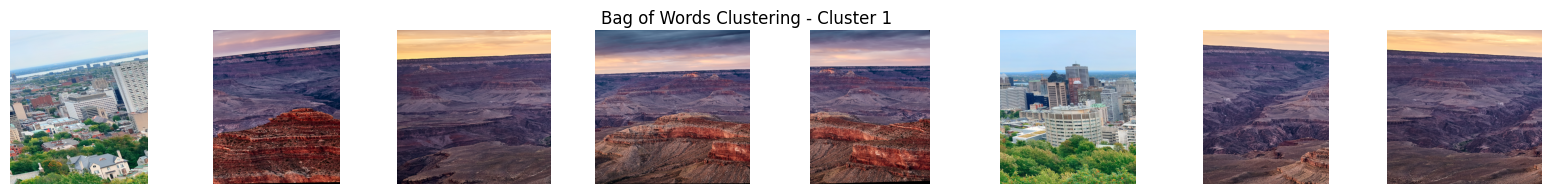

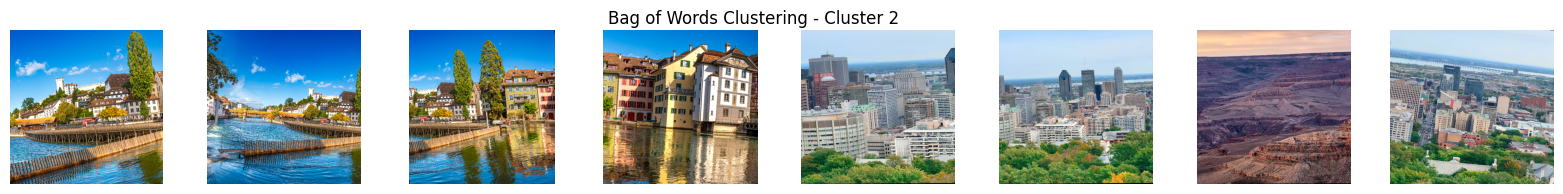

In [12]:
bow_features = bag_of_words(image_paths)
bow_labels = cluster_images(bow_features, n_clusters=3)
visualize_clusters(image_paths, bow_labels, "Bag of Words Clustering")

In [13]:
def compute_match_score(matches, img1, img2, kp1, kp2):
    """
    Computes the match score based on the number of matches.
    """
    w1 = img1.shape[1]
    w2 = img2.shape[1]

    x_cords = [(kp1[m.queryIdx].pt[0], kp2[m.trainIdx].pt[0]) for m in matches]

    score_LR = np.mean([(w1-kp1_x + kp2_x) for kp1_x,kp2_x in x_cords]).astype(np.int32)
    score_RL = np.mean([(w2-kp2_x + kp1_x) for kp1_x,kp2_x in x_cords]).astype(np.int32)

    return score_LR, score_RL

def sort_images_by_features(images):
    """
    Sorts images in a logical sequence using feature matching.
    """

    image_keypoints = []
    image_descriptors = []

    for img in images:
        kp, desc = detect_keypoints(img)
        image_keypoints.append(kp)
        image_descriptors.append(desc)

    num_images = len(images)
    match_score = np.zeros((num_images, num_images))
    total_matches = np.zeros((num_images, num_images))

    # Compute feature matches between all image pairs
    for i in range(num_images):
        for j in range(i + 1, num_images):
            matches = match_features(images[i], image_keypoints[i], image_descriptors[i],
                                    images[j], image_keypoints[j], image_descriptors[j], method="FlannBased")

            total_matches[i][j], total_matches[j][i] = len(matches), len(matches)
            match_score[i][j], match_score[j][i] = compute_match_score(matches, images[i], images[j],
                                                                image_keypoints[i], image_keypoints[j])

    graph = {}
    sorted_indices = []
    for i in range(num_images):
        top_match2, top_match1 = np.argsort(total_matches[i])[-2:]
        if(total_matches[i][top_match2] < 200): 
            continue

        _1toi = match_score[top_match1][i]
        _2toi = match_score[top_match2][i]
        _ito1 = match_score[i][top_match1]
        _ito2 = match_score[i][top_match2]

        if  _1toi < _ito1 and _ito2 < _2toi: 
            graph[top_match1] = i
            graph[i] = top_match2
        elif _2toi < _ito2 and _ito1 < _1toi:
            graph[top_match2] = i
            graph[i] = top_match1

    start_idx  =  (num_images*(num_images-1)//2) - sum(graph.values()) 
    
    sorted_indices.append(start_idx)
    while len(sorted_indices) < num_images:
        next_idx = graph[sorted_indices[-1]]
        sorted_indices.append(next_idx)

    return [images[i] for i in sorted_indices]


def binary_stitch(img1, img2, cropping = True, draw=False):
    """
    Stitches two images together with blending and cropping.
    """
    # Detect keypoints and compute descriptors
    kp1, desc1 = detect_keypoints(img1)
    kp2, desc2 = detect_keypoints(img2)

    # Match features using FlannBased method
    flann_matches = match_features(img1, kp1, desc1, img2, kp2, desc2, method="FlannBased")
    
    # Compute the homography matrix
    H = compute_homography(kp1, kp2, flann_matches)

    # Warp and blend the images
    stitched_image = stitch_with_blend(img1, img2, H)

    # Crop the blended image to remove black pixels
    if cropping:
        stitched_image = crop(stitched_image)

    if draw and crop:
        plt.imshow(cv2.cvtColor(stitched_image, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title("Stitched Image (Blended and Cropped)")
        plt.show()

    return stitched_image


def multi_stitch(images, draw=False):
    """
    Stitches multiple images together to create a panorama.
    Uses feature-based sorting before stitching.
    """
    # Sort images based on features
    images = sort_images_by_features(images)

    stitched_image = images[0]
    for i in range(1, len(images)):
        stitched_image = binary_stitch(stitched_image, images[i], cropping=False)

    stitched_image = crop(stitched_image)

    if draw:
        plt.imshow(cv2.cvtColor(stitched_image, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title("Panorama")
        plt.show()

    return stitched_image

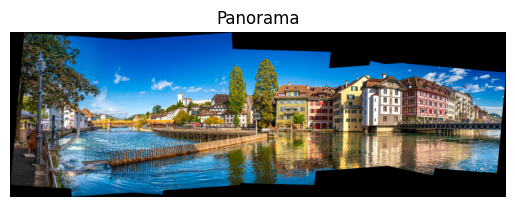

Stitched image saved to cluster0_panorama.png


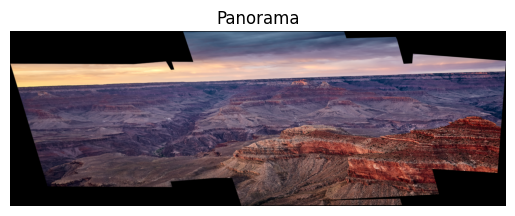

Stitched image saved to cluster1_panorama.png


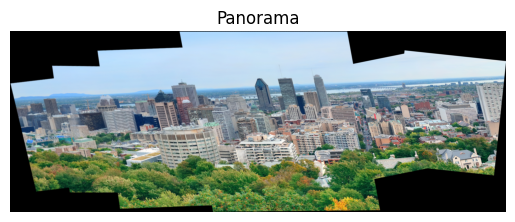

Stitched image saved to cluster2_panorama.png


In [14]:
for cluster in np.unique(color_hist_labels):
    cluster_indices = np.where(color_hist_labels == cluster)[0]

    # Read and stitch the images in the cluster
    images = [cv2.imread(image_paths[i]) for i in cluster_indices]

    panorama = multi_stitch(images, draw=True)

    # Save the stitched image
    output_path = f"cluster{cluster}_panorama.png"
    cv2.imwrite(output_path, panorama)
    print(f"Stitched image saved to {output_path}")

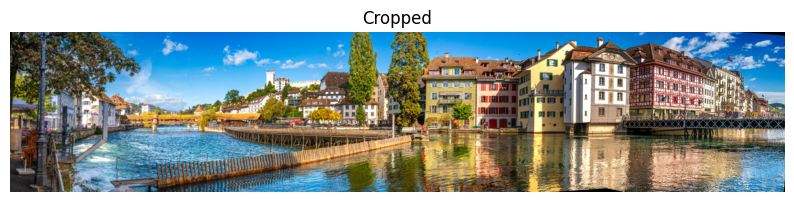

Stitched image saved to cluster0_panorama_zoomed.png


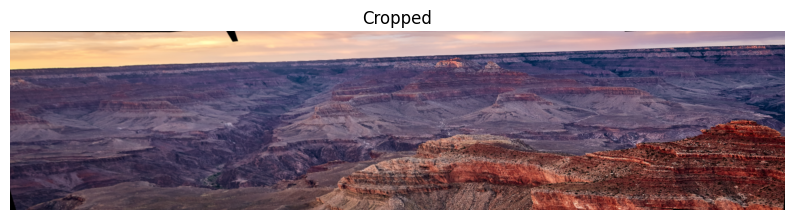

Stitched image saved to cluster1_panorama_zoomed.png


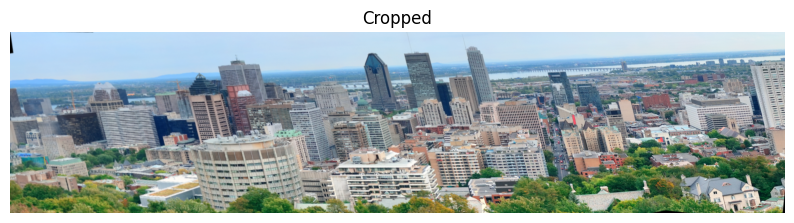

Stitched image saved to cluster2_panorama_zoomed.png


In [21]:
for cluster in np.unique(color_hist_labels):
    panorama = cv2.imread(f"cluster{cluster}_panorama.png")

    panorama_zoomed = crop(panorama, threshold=0.90, draw=True)
    
    # Save the stitched image
    output_path = f"cluster{cluster}_panorama_zoomed.png"
    cv2.imwrite(output_path, panorama_zoomed)
    print(f"Stitched image saved to {output_path}")